In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from math import sqrt

from core.data.file_processing import open_all_data, generate_all_monthly_data, inferred_land_sink, all_dgvms_gl
from core.data.data_processing import trend
from core.modeling import prep_data, define_model_and_train, evaluate_model, baseline, basic_linear_model

# Import data 

In [3]:
df = open_all_data()
df_no_na = df.dropna()
df_no_na.index = pd.to_datetime(df_no_na.index).to_period("M")
df_iav = trend(df_no_na)

df_inf = inferred_land_sink()
df_inf = df_inf.dropna()
df_inf['Inferred_land_sink'] = df_inf['GL_ff_emissions'] \
                             + df_inf['LUC'] \
                             - df_inf['monthly_gr'] \
                             + df_inf['ocean_sink_GL'] # because already negative
df_inf['Inferred_land_sink'] = -1 * df_inf['Inferred_land_sink']
del df_inf['LUC_blue']
df_inf_iav = trend(df_inf)

In [4]:
df_iav.columns
df_iav_select = df_iav[['land_sink_GL', 'Landtemp_GL', 'Landtemp_TR', 'Pre_GL', 'Pre_TR', 'ENSO']]

In [5]:
df_all = df_iav_select[1:].merge(df_inf_iav, left_index=True, right_index=True)
df_all

,land_sink_GL,Landtemp_GL,Landtemp_TR,Pre_GL,Pre_TR,ENSO,GL_ff_emissions,LUC,monthly_gr,ocean_sink_GL,Inferred_land_sink
time,,,,,,,,,,,
1980-02,0.092564,-0.283749,0.449947,67.260871,91.321893,0.5,0.457083,0.053399,0.087450,-0.105787,-0.317245
1980-03,0.086849,-0.241958,0.427786,67.368384,91.484640,0.3,0.455417,0.053266,0.103350,-0.105750,-0.299584
1980-04,0.081135,-0.200168,0.405626,67.475897,91.647387,0.4,0.453752,0.053134,0.119250,-0.105713,-0.281922
1980-05,0.075420,-0.158377,0.383465,67.583410,91.810135,0.5,0.452086,0.053001,0.135150,-0.105676,-0.264261
1980-06,0.069705,-0.116586,0.361305,67.690923,91.972882,0.5,0.450420,0.052868,0.151050,-0.105639,-0.246600
...,...,...,...,...,...,...,...,...,...,...,...
2019-08,-0.115516,1.163805,0.914567,69.557906,93.454402,0.1,0.829802,0.074851,0.436367,-0.167454,-0.300833
2019-09,-0.112590,1.176326,0.927641,69.428300,93.438218,0.2,0.829934,0.076606,0.467283,-0.168301,-0.270956
2019-10,-0.109141,1.189851,0.934879,69.458855,93.631625,0.3,0.830060,0.078362,0.491133,-0.168958,-0.248330


In [6]:
# Select data
dependent_variable = 'Inferred_land_sink'
independent_variables = ['Landtemp_GL',
                         'Pre_GL',
                         'GL_ff_emissions',
                         'LUC'
                        ]

variables = [dependent_variable] + independent_variables
df_use = df_all[variables]

In [ ]:
def prep_data(df_in, dependent_variable, train_p_l=0, train_p=0.7, val_p=0.85, test_p=1):
    # train_p is the percent of data used in train, 
    # val_p is how much more is used in the val set
    df = df_in.copy()
    
    # DEFINE TARGET USING WINDOW SHIFT
    df['y'] = df[dependent_variable].shift(-1)
    df = df.dropna()
    del df[dependent_variable]
    
    # SPLIT INTO TRAIN, VAL, AND TEST
    n = len(df)
    train_df = df[int(n*train_p_l):int(n*train_p)]
    val_df = df[int(n*train_p):int(n*val_p)]
    test_df = df[int(n*val_p):int(n*test_p)]
    num_features = df.shape[1]
    print("There are {} in the training set, {} for val, and {} for testing."
          .format(len(train_df), len(val_df), len(test_df)))
    
    # NORMALIZE
    # The mean and standard deviation should only be computed using 
    # the training data so that the models have no access to the values 
    #     in the validation and test sets
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    # DEFINE TARGET USING WINDOW SHIFT
    train_y = train_df.pop('y')
    val_y = val_df.pop('y')
    test_y = test_df.pop('y')
        
    # RESHAPE
    # LSTM expects format of [samples, timestep, features]
    # Here, the shape is for a single-step model which predicts a single feature's value 
    # one timestep in the future based on current conditions.
    train_X = train_df.values.reshape((train_df.shape[0], 1, train_df.shape[1]))
    val_X = val_df.values.reshape((val_df.shape[0], 1, val_df.shape[1]))
    test_X = test_df.values.reshape((test_df.shape[0], 1, test_df.shape[1]))
    
    return train_X, val_X, test_X, train_y, val_y, test_y

In [ ]:
def define_model_and_train(train_X, train_y, val_X, val_y):

    callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation='relu'))
    model.add(LSTM(50, return_sequences=False, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y,
                        epochs=50,
                        batch_size=12,
                        validation_data=(val_X, val_y),
                        verbose=0,
                        shuffle=False,
                        callbacks=[callback])
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()
    return model


def evaluate_model(model, test_X, test_y):
	# todo: invert scaling for forecast
	# calculate RMSE
	yhat = model.predict(test_X)
	rmse = sqrt(mean_squared_error(test_y, yhat))
	print('Test RMSE: %.3f' % rmse)
	# plot the results
	results = pd.DataFrame(index=test_y.index)
	results['observed'] = test_y
	results['predicted'] = yhat
	results.plot()

In [ ]:
# train test splits
train_X, val_X, test_X, train_y, val_y, test_y = prep_data(df_use, dependent_variable, 0, 0.5, 0.7, 0.8)
model = define_model_and_train(train_X, train_y, val_X, val_y)
evaluate_model(model, test_X, test_y)

train_X, val_X, test_X, train_y, val_y, test_y = prep_data(df_use, dependent_variable, 0.1, 0.6, 0.8, 0.9)
model = define_model_and_train(train_X, train_y, val_X, val_y)
evaluate_model(model, test_X, test_y)

train_X, val_X, test_X, train_y, val_y, test_y = prep_data(df_use, dependent_variable, 0.2, 0.7, 0.9, 1)
model = define_model_and_train(train_X, train_y, val_X, val_y)
evaluate_model(model, test_X, test_y)


In [ ]:
train_X, val_X, test_X, train_y, val_y, test_y = prep_data(df_use, dependent_variable)
model = define_model_and_train(train_X, train_y, val_X, val_y)
evaluate_model(model, test_X, test_y)

In [ ]:
def baseline(test_X, test_y):
	yhat = test_y.shift(1) # This returns the prediction as the previous value.
	yhat[0] = yhat[1]
	rmse = sqrt(mean_squared_error(test_y, yhat))
	print('Test RMSE: %.3f' % rmse)
	results = pd.DataFrame(index=test_y.index)
	results['observed'] = test_y
	results['predicted'] = yhat
	results.plot()


def basic_linear_model(train_X, train_y, test_X, test_y):
	reg = linear_model.LinearRegression()
	reg.fit(train_X.reshape(train_X.shape[0],train_X.shape[2]), train_y)
	yhat = reg.predict(test_X.reshape(test_X.shape[0],test_X.shape[2]))
	rmse = sqrt(mean_squared_error(test_y, yhat))
	print('Test RMSE: %.3f' % rmse)
	results = pd.DataFrame(index=test_y.index)
	results['observed'] = test_y
	results['predicted'] = yhat
	results.plot()


In [ ]:
baseline(test_X, test_y)

In [ ]:
basic_linear_model(train_X, train_y, test_X, test_y)

In [19]:
df = df_use.copy()

In [20]:
df

,Inferred_land_sink,Landtemp_GL,Pre_GL,GL_ff_emissions,LUC
time,,,,,
1980-02,-0.317245,-0.283749,67.260871,0.457083,0.053399
1980-03,-0.299584,-0.241958,67.368384,0.455417,0.053266
1980-04,-0.281922,-0.200168,67.475897,0.453752,0.053134
1980-05,-0.264261,-0.158377,67.583410,0.452086,0.053001
1980-06,-0.246600,-0.116586,67.690923,0.450420,0.052868
...,...,...,...,...,...
2019-08,-0.300833,1.163805,69.557906,0.829802,0.074851
2019-09,-0.270956,1.176326,69.428300,0.829934,0.076606
2019-10,-0.248330,1.189851,69.458855,0.830060,0.078362


In [21]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [22]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [62]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
              [labels[:, :, self.column_indices[name]] for name in self.label_columns],
              axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    
    def plot(self, model=None, plot_col='Inferred_land_sink', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
        
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Months')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1, # Period between successive output sequences. 
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result        

In [63]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [64]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [65]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['Inferred_land_sink'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Inferred_land_sink']

In [66]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [67]:
baseline = Baseline(label_index=column_indices['Inferred_land_sink'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 2ms/step - loss: 0.0658 - mean_absolute_error: 0.1928


In [68]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['Inferred_land_sink'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Inferred_land_sink']

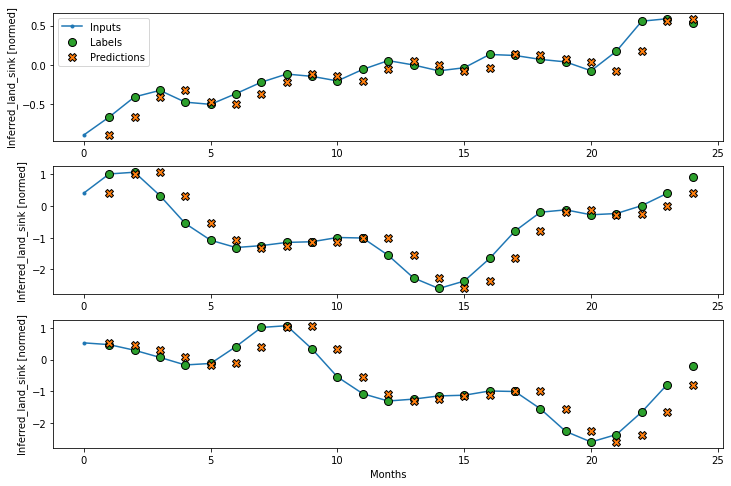

In [69]:
wide_window.plot(baseline)

In [70]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [75]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
11/11 [==============================] - 0s 14ms/step - loss: 1.6474 - mean_absolute_error: 1.0206 - val_loss: 1.6249 - val_mean_absolute_error: 1.0158
Epoch 2/20
11/11 [==============================] - 0s 6ms/step - loss: 1.5789 - mean_absolute_error: 1.0002 - val_loss: 1.7270 - val_mean_absolute_error: 1.0487
Epoch 3/20
3/3 [==============================] - 0s 1ms/step - loss: 1.8321 - mean_absolute_error: 1.0833


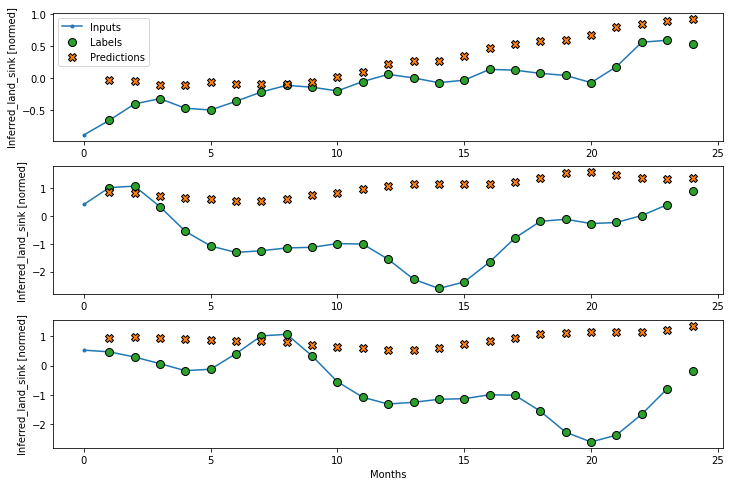

In [76]:
wide_window.plot(linear)

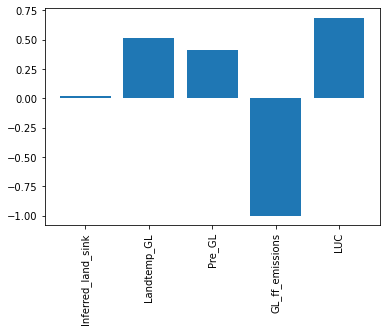

In [77]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [78]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
11/11 [==============================] - 1s 17ms/step - loss: 1.0856 - mean_absolute_error: 0.8212 - val_loss: 0.5025 - val_mean_absolute_error: 0.5820
Epoch 2/20
11/11 [==============================] - 0s 8ms/step - loss: 0.5211 - mean_absolute_error: 0.5552 - val_loss: 0.2808 - val_mean_absolute_error: 0.3990
Epoch 3/20
11/11 [==============================] - 0s 6ms/step - loss: 0.2533 - mean_absolute_error: 0.3788 - val_loss: 0.2741 - val_mean_absolute_error: 0.4021
Epoch 4/20
11/11 [==============================] - 0s 6ms/step - loss: 0.1225 - mean_absolute_error: 0.2634 - val_loss: 0.1803 - val_mean_absolute_error: 0.3257
Epoch 5/20
11/11 [==============================] - 0s 7ms/step - loss: 0.0860 - mean_absolute_error: 0.2242 - val_loss: 0.2311 - val_mean_absolute_error: 0.3996
Epoch 6/20
3/3 [==============================] - 0s 1ms/step - loss: 0.3160 - mean_absolute_error: 0.4883


In [80]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [81]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


In [82]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
10/10 [==============================] - 2s 47ms/step - loss: 0.7286 - mean_absolute_error: 0.6624 - val_loss: 1.0344 - val_mean_absolute_error: 0.9013
Epoch 2/20
10/10 [==============================] - 0s 13ms/step - loss: 0.5365 - mean_absolute_error: 0.5568 - val_loss: 0.8023 - val_mean_absolute_error: 0.7892
Epoch 3/20
10/10 [==============================] - 0s 12ms/step - loss: 0.4147 - mean_absolute_error: 0.4843 - val_loss: 0.5538 - val_mean_absolute_error: 0.6439
Epoch 4/20
10/10 [==============================] - 0s 12ms/step - loss: 0.3468 - mean_absolute_error: 0.4468 - val_loss: 0.4012 - val_mean_absolute_error: 0.5285
Epoch 5/20
10/10 [==============================] - 0s 11ms/step - loss: 0.2971 - mean_absolute_error: 0.4154 - val_loss: 0.2941 - val_mean_absolute_error: 0.4352
Epoch 6/20
10/10 [==============================] - 0s 12ms/step - loss: 0.2616 - mean_absolute_error: 0.3887 - val_loss: 0.2525 - val_mean_absolute_error: 0.3942
Epoch 7/20
10/10 [====

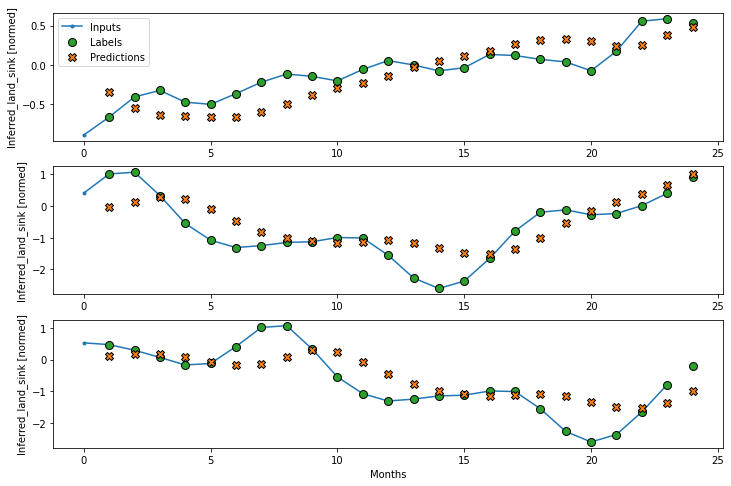

In [83]:
wide_window.plot(lstm_model)

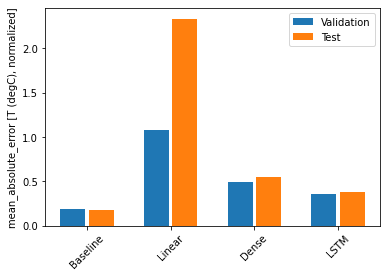

In [84]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [50]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')  

Baseline    : 0.1727
Linear      : 2.5672
Dense       : 0.5392
LSTM        : 0.3540


In [ ]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta